In [2]:
project      = 'hoshinolab_proteomics_age'
from bin import nimb_link
NIMB_HOME = nimb_link.link_with_nimb()
from setup.get_vars import Get_Vars, SetProject
from distribution import utilities as utils
from stats.db_processing import Table
from stats.preprocessing import Preprocess
from stats import preprocessing, varia
from stats.make_stats_grid import MakeGrid
from stats.stats_models import ANOVA_do
from stats.plotting import Make_Plot_Regression, Make_plot_group_difference
from stats import predict
tab = Table()

all_vars = Get_Vars()
project_vars = all_vars.projects[project]

getvars      = Get_Vars()
nimb_stats   = getvars.stats_vars
projects     = getvars.projects
NIMB_tmp     = getvars.location_vars['local']['NIMB_PATHS']['NIMB_tmp']
fname_groups = projects[project]["fname_groups"]
nimb_stats   = SetProject(NIMB_tmp, nimb_stats, project, fname_groups).stats
project_vars = projects[project]
stats_paths  = nimb_stats['STATS_PATHS']
vars_glm     = project_vars['variables_for_glm']

/home/ssp/Dropbox/github/nimb/nimb
        credentials are located at: /home/ssp/nimb
        credentials are located at: /home/ssp/nimb


In [3]:
# ATTENTION: prediction_target MUST be a group column, that will be converted to y_label
# extracting features based on PCA
def get_X_data_per_group_all_groups(group):
    # extract X_scaled values for the brain parameters
        predicted_target = project_vars["prediction_target"]
        if not predicted_target:
            predicted_target = project_vars["group_col"]
        if group == 'all':
                df_clin_group = df_user_stats
                df_X          = df_adjusted
                y_labeled     = preprocessing.label_y(df_user_stats, predicted_target)
                X_scaled      = preprocessing.scale_X(df_X)
        else:
                df_group      = tab.get_df_per_parameter(df_final_grid, project_vars['group_col'], group)
                df_clin_group = tab.rm_cols_from_df(df_group, cols_X)
                df_X          = tab.rm_cols_from_df(df_group, [i for i in df_group.columns.tolist() if i not in cols_X])
                y_labeled     = preprocessing.label_y(df_group, predicted_target)
                X_scaled      = preprocessing.scale_X(df_X)
        return df_X, y_labeled, X_scaled, df_clin_group

In [4]:
from os import path
def get_features_df_per_group(group, X_scaled, y_labeled, df_X, pca_threshold):
        features_rfe_and_rank_df = 'none'
        if use_features:
            if feature_algo == 'PCA':# using PCA
                    features = predict.get_features_based_on_pca(
                                        varia.get_dir(path.join(stats_paths['STATS_HOME'],
                                                                stats_paths['features'])),
                                        pca_threshold,
                                        X_scaled, cols_X,
                                        group, atlas, lang)
            elif feature_algo == 'RFE': # using RFE
                    features, features_rfe_and_rank_df = predict.feature_ranking(X_scaled,
                                                                        y_labeled,
                                                                        self.cols_X)
                    print("    number of features extracted by RFE: ",len(features_rfe_and_rank_df.feature))
            df_with_features = tab.get_df_from_df(df_X, usecols = features)
        else:
            df_with_features = tab.get_df_from_df(df_X, usecols = cols_X)
            features = cols_X
        return df_with_features, features, features_rfe_and_rank_df

In [5]:
df_user_stats, df_final_grid,\
            df_adjusted,\
            cols_X,\
            groups = MakeGrid(project_vars,
                                nimb_stats).grid()

#this grid has an error, as the former index is being saved as a column and must be removed
col2rm = 'Unnamed: 0'
df_final_grid.drop(columns=[col2rm], inplace=True)
df_adjusted.drop(columns=[col2rm], inplace=True)
cols_X.remove(col2rm)

    reading file: /media/g/nimb_tmp/projects/hoshinolab_proteomics_age/stats_src/stats/stats_src.xlsx,
        sheet: 0
    reading file: /media/g/nimb_tmp/projects/hoshinolab_proteomics_age/stats_src/stats/grid.csv,
        sheet: 0


In [6]:
group = 'all'
predicted_target = project_vars["prediction_target"]
print(f'y_labeled predicted target is: {predicted_target}')
df_X, y_labeled, X_scaled, df_clin_group = get_X_data_per_group_all_groups(group)

y_labeled predicted target is: ['group']
PowerTransformer()


In [15]:
# DONE: STEP 1 ANOVA
# DONE: STEP 2 Simple Linear Regression

# some cols have zeros and because of them ANOVA cannot be performed.
# this step removes the columns with at least 1 zero

cols_with_zeros = list()
for col in df_final_grid.columns:
    n = df_final_grid[col].isin([0]).sum()
    if n>0:
        cols_with_zeros.append(col)
#(df_final_grid == 0).astype(int).sum(axis=0)
#(df_final_grid == 0).sum(axis=1)

df_final_grid.drop(columns=cols_with_zeros, inplace=True)
features = [i for i in cols_X if i not in cols_with_zeros+[col2rm,]]
vars_glm = features#[i for i in vars_glm if i not in cols_with_zeros+[col2rm,]]

# for ANOVA zeros must be removed

sig_cols = ANOVA_do(df_final_grid,
                    vars_glm, features,
                    varia.get_dir(stats_paths['anova']),
                    p_thresh = 0.05, intercept_thresh = 0.05).sig_cols
Make_Plot_Regression(df_final_grid,
                    sig_cols, project_vars['group_col'],
                    varia.get_dir(stats_paths['simp_lin_reg_dir']))
#Make_plot_group_difference(df_final_grid,
#                            sig_cols, project_vars['group_col'], groups,
#                            varia.get_dir(stats_paths['anova']))

y_labeled predicted target is: ['group'], group param age is EXCLUDED
PowerTransformer()
    nr of features to analyze by PCA: 53
    PCA chose 19 components and 15 features 
P13671 not defined
P60709 not defined
O43866 not defined
CON_Trypsin not defined
P02776 not defined
P01876 not defined
P04275 not defined
P02042 not defined
A6NNI4 not defined
P26038 not defined
P04114 not defined
P02765 not defined
P00488 not defined
P01593 not defined
P00450 not defined


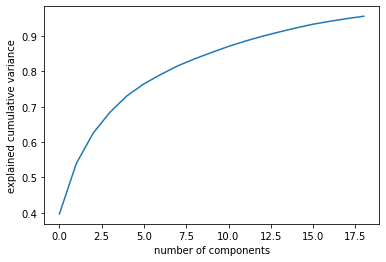

In [11]:
# DONE: STEP 3 PCA features extract
#group param is removed to exclude from prediction algo
group = 'all'
predicted_target = project_vars["prediction_target"]
group_param = project_vars['group_param']
df_user_stats.drop(columns=[group_param], inplace=True)
df_final_grid.drop(columns=[group_param], inplace=True)
df_adjusted.drop(columns=[group_param], inplace=True)
cols_X.remove(group_param)
print(f'y_labeled predicted target is: {predicted_target}, group param {group_param} is EXCLUDED')

df_X, y_labeled, X_scaled, df_clin_group = get_X_data_per_group_all_groups(group)

# ================================
use_features = True
feature_algo = "PCA"
atlas = "DK"
lang='EN'
features = cols_X #specific for the hoshinolab_proteomics_age project
pca_threshold = 0.95#nimb_stats["STATS_PARAMS"]["prediction_vars"]['pca_threshold']
df_with_features, features, features_rfe_and_rank_df = get_features_df_per_group(group, X_scaled, y_labeled,
                                                                                 df_X, pca_threshold)

In [12]:
# DONE: STEP 4 predict usign SKF and LOO

features = cols_X #specific for the hoshinolab_proteomics_age project
skf_NUM_ITER = nimb_stats["STATS_PARAMS"]["prediction_vars"]['skf_NUM_ITER']
loo_NUM_ITER = nimb_stats["STATS_PARAMS"]["prediction_vars"]['NUM_ITER']
print(f'y_labeled predicted target is: {predicted_target}')

STEP_Predict = True
STEP_Predict_RF_SKF = True
STEP_Predict_RF_LOO = False

if STEP_Predict:
    # STEP run Prediction RF SKF
    if STEP_Predict_RF_SKF:
        print('    performing RF SKF Prediction for all groups')
        df_X_scaled = tab.create_df(X_scaled, index_col=range(X_scaled.shape[0]), cols=cols_X)
        accuracy, best_estimator, average_score_list, _ = predict.SKF_algorithm(
                features, df_X_scaled[features].values, y_labeled, skf_NUM_ITER)
        print("    prediction accuracy computed with RF and SKF based on PCA features is: ",accuracy)
        # accuracy, best_estimator, average_score_list, _ = predict.SKF_algorithm(
        #         features_rfe_and_rank_df.feature, df_X_scaled[features_rfe_and_rank_df.feature].values, y_labeled)
        # print("prediction accuracy computed with RF and SKF based on RFE features is: ", accuracy)

    # STEP run Prediction RF LOO
    if STEP_Predict_RF_LOO:
        print('performing RF Leave-One_out Prediction for all groups')
        df_X_scaled = tab.create_df(X_scaled, index_col=range(X_scaled.shape[0]), cols=cols_X)
        accuracy, best_estimator, average_score_list, _ = predict.LOO_algorithm(
                features, df_X_scaled[features].values, y_labeled, loo_NUM_ITER)
        print("    prediction accuracy computed with RF and SKF based on PCA features is: ",accuracy)
        accuracy, best_estimator, average_score_list, _ = predict.LOO_algorithm(
                features_rfe_and_rank_df.feature, df_X_scaled[features_rfe_and_rank_df.feature].values,
                y_labeled, loo_NUM_ITER)
        print("    prediction accuracy computed with RF and SKF based on RFE features is: ", accuracy)


y_labeled predicted target is: ['group']
    performing RF SKF Prediction for all groups
RandomForestClassifier(bootstrap=False, max_depth=30, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=10,
                       random_state=42, verbose=False)
    prediction accuracy computed with RF and SKF based on PCA features is:  0.8346153846153846


In [10]:
group = 'all'
predicted_target = ["age"]
print(f'y_labeled predicted target is: {predicted_target}')
df_X, y_labeled, X_scaled, df_clin_group = get_X_data_per_group_all_groups(group)

y_labeled predicted target is: ['group']
